***Anurag Sharma (24AI91R01)***

In [19]:
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available: ", cuda_available)

CUDA Available:  True


# Task 1 - Load and Prepare the Oxford-IIIT Pets Dataset

In [3]:
# Define a transformation to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# We load the trainval partition for training and validation
trainval_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)

# We load the test partition for testing
test_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)

100%|██████████| 791918971/791918971 [00:21<00:00, 37298679.60it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16522265.88it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [4]:
print(f"Number of samples in train_val_set: {len(trainval_dataset)}")
print(f"Number of samples in test_set: {len(test_dataset)}")

Number of samples in train_val_set: 3680
Number of samples in test_set: 3669


There are 37 classes in the dataset

In [5]:
classes = trainval_dataset.classes
print(f"Number of classes in the dataset: {len(classes)}")
# Print class names
print("Class labels and their corresponding names:")
for idx, class_name in enumerate(classes):
    print(f"Label {idx}: {class_name}")

Number of classes in the dataset: 37
Class labels and their corresponding names:
Label 0: Abyssinian
Label 1: American Bulldog
Label 2: American Pit Bull Terrier
Label 3: Basset Hound
Label 4: Beagle
Label 5: Bengal
Label 6: Birman
Label 7: Bombay
Label 8: Boxer
Label 9: British Shorthair
Label 10: Chihuahua
Label 11: Egyptian Mau
Label 12: English Cocker Spaniel
Label 13: English Setter
Label 14: German Shorthaired
Label 15: Great Pyrenees
Label 16: Havanese
Label 17: Japanese Chin
Label 18: Keeshond
Label 19: Leonberger
Label 20: Maine Coon
Label 21: Miniature Pinscher
Label 22: Newfoundland
Label 23: Persian
Label 24: Pomeranian
Label 25: Pug
Label 26: Ragdoll
Label 27: Russian Blue
Label 28: Saint Bernard
Label 29: Samoyed
Label 30: Scottish Terrier
Label 31: Shiba Inu
Label 32: Siamese
Label 33: Sphynx
Label 34: Staffordshire Bull Terrier
Label 35: Wheaten Terrier
Label 36: Yorkshire Terrier


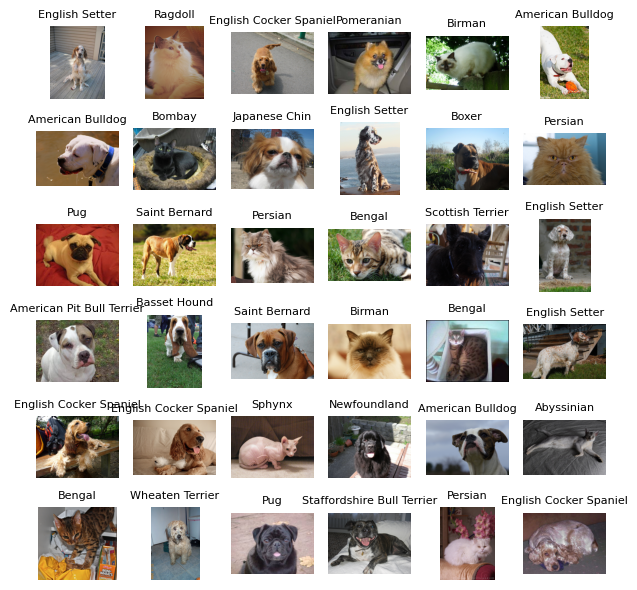

In [6]:
# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')  # Hide axes

# Function to visualize samples from the dataset
def visualize_samples(dataset, num_samples=12, images_per_row=4):
    # Ensure num_samples is a perfect square for a square grid
    num_rows = num_samples // images_per_row

    # Select a few samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # Prepare the figure for plotting
    plt.figure(figsize=(images_per_row , num_rows ))  # Adjust figure size

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # Create a subplot for each image
        plt.subplot(num_rows, images_per_row, i + 1)
        imshow(img)
        plt.title(classes[label], fontsize=8)  # Adjust font size for readability

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Visualize sample images
visualize_samples(trainval_dataset, num_samples=36, images_per_row=6)

In [7]:
# Convert class labels into one-hot encoded format.
def one_hot_encode(labels, num_classes):
  return np.eye(num_classes)[labels]

num_classes = len(classes)
trainval_labels = [label for _, label in trainval_dataset]
trainval_labels_one_hot = one_hot_encode(trainval_labels, num_classes)
print("Shape of one-hot encoded trainval labels:", trainval_labels_one_hot.shape)

Shape of one-hot encoded trainval labels: (3680, 37)


In [8]:
# Select a few random indices
num_samples_to_display = 5
random_indices = random.sample(range(len(trainval_labels_one_hot)), num_samples_to_display)

# Display the one-hot encoded labels and their corresponding class names
for index in random_indices:
  print(f"Index: {index}")
  print(f"One-hot encoded label: {trainval_labels_one_hot[index]}")
  print(f"Class name: {classes[trainval_labels[index]]}")
  print("-" * 20)

Index: 2633
One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class name: Great Pyrenees
--------------------
Index: 12
One-hot encoded label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class name: Abyssinian
--------------------
Index: 1781
One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Class name: Wheaten Terrier
--------------------
Index: 1304
One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class name: Ragdoll
--------------------
Index: 3673
One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Class name: Yorkshire Terrier
--------------------


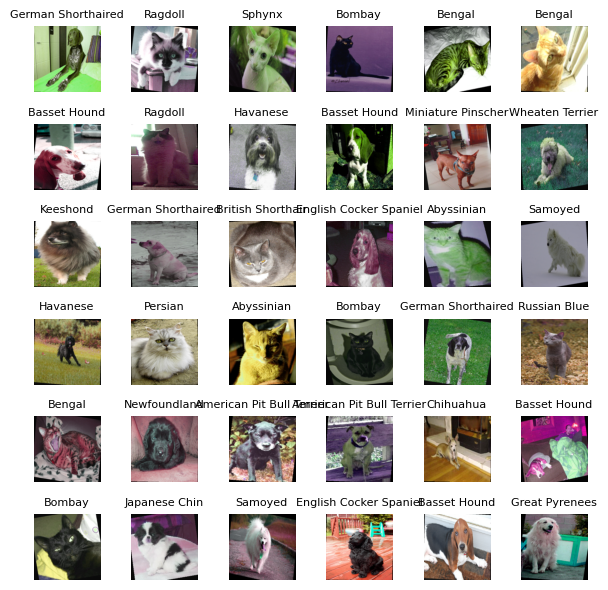

In [9]:
# We resize using torchvision.transforms. Resizing all images to 128x128 pixels with bicubic interpolation.
transform_resize = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Reload the datasets with the new transform
trainval_dataset_resized = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True,
                                                            transform=transform_resize)
test_dataset_resized = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True,
                                                          transform=transform_resize)

# Visualize sample images from the resized dataset
visualize_samples(trainval_dataset_resized, num_samples=36, images_per_row=6)

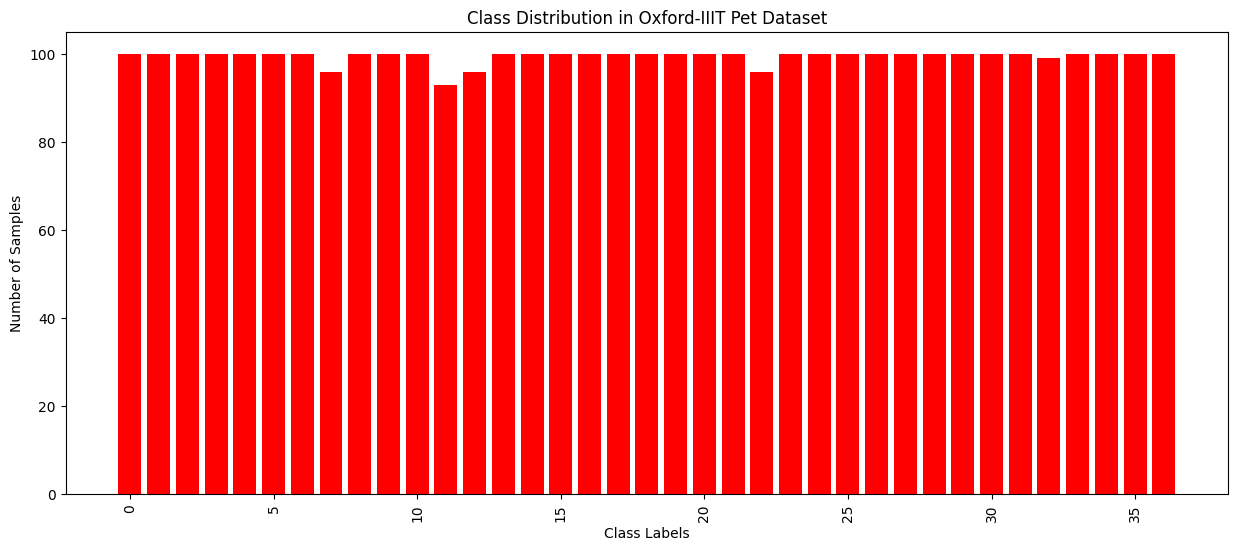

In [29]:
# Class Distribution
# Count the number of samples for each class
class_counts = Counter([label for _, label in trainval_dataset])

# Create a bar graph
plt.figure(figsize=(15, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='red')
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Oxford-IIIT Pet Dataset")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

# Task 2 - Data Splitting

In [11]:
# Get labels for the trainval dataset
trainval_labels = [label for _, label in trainval_dataset_resized]

# Stratified split to maintain class distribution
train_indices, val_indices = train_test_split(
    list(range(len(trainval_dataset_resized))),
    test_size=0.2,
    stratify=trainval_labels,
    random_state=42
)

In [12]:
# Create training and validation datasets using the indices
train_dataset = torch.utils.data.Subset(trainval_dataset_resized, train_indices)
val_dataset = torch.utils.data.Subset(trainval_dataset_resized, val_indices)

# Print the number of samples in each partition
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset_resized)}")

Number of training samples: 2944
Number of validation samples: 736
Number of testing samples: 3669


In [13]:
# Check class distribution in each partition
train_class_counts = Counter([trainval_dataset_resized[i][1] for i in train_indices])
val_class_counts = Counter([trainval_dataset_resized[i][1] for i in val_indices])
test_class_counts = Counter([label for _, label in test_dataset_resized])

print("Training Class Distribution:", train_class_counts)
print("Validation Class Distribution:", val_class_counts)
print("Testing Class Distribution:", test_class_counts)

Training Class Distribution: Counter({33: 80, 19: 80, 5: 80, 34: 80, 17: 80, 16: 80, 29: 80, 23: 80, 24: 80, 30: 80, 35: 80, 14: 80, 20: 80, 36: 80, 8: 80, 10: 80, 4: 80, 31: 80, 13: 80, 27: 80, 2: 80, 6: 80, 3: 80, 25: 80, 1: 80, 18: 80, 0: 80, 26: 80, 9: 80, 15: 80, 28: 80, 21: 80, 32: 79, 22: 77, 12: 77, 7: 77, 11: 74})
Validation Class Distribution: Counter({1: 20, 29: 20, 0: 20, 30: 20, 16: 20, 34: 20, 24: 20, 17: 20, 25: 20, 33: 20, 20: 20, 18: 20, 2: 20, 5: 20, 9: 20, 8: 20, 27: 20, 6: 20, 36: 20, 31: 20, 21: 20, 14: 20, 15: 20, 28: 20, 19: 20, 10: 20, 35: 20, 23: 20, 3: 20, 26: 20, 13: 20, 32: 20, 4: 20, 22: 19, 11: 19, 7: 19, 12: 19})
Testing Class Distribution: Counter({1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 9: 100, 10: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 31: 100, 32: 100, 33: 100, 35: 100, 36: 100, 8: 99, 18: 99, 30: 99, 0: 98, 11: 97, 34: 89, 7:

In [14]:
print("Dataset sizes:")
print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Dataset sizes:
Training set: 2944
Validation set: 736
Test set: 3669


# Task 3 -  Design a CNN Model

In [15]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        # Initialize the parent class
        super(MyCNN, self).__init__()

        # Convolutional layer 1: Input channels = 3 (RGB), Output channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        # Batch normalization for the first convolutional layer
        self.bn1 = nn.BatchNorm2d(64)
        # Max pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2: Input channels = 64, Output channels = 128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Batch normalization for the second convolutional layer
        self.bn2 = nn.BatchNorm2d(128)

        # Convolutional layer 3: Input channels = 128, Output channels = 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # Batch normalization for the third convolutional layer
        self.bn3 = nn.BatchNorm2d(256)

        # Fully connected layer 1: Input size = 256*16*16 (assuming input size reduction)
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        # Fully connected layer 2: Input size = 1024, Output size = 512
        self.fc2 = nn.Linear(1024, 512)
        # Fully connected layer 3: Output layer with 'num_classes' neurons
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the first convolutional layer, followed by batch norm, ReLU, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Forward pass through the second convolutional layer, followed by batch norm, ReLU, and max pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Forward pass through the third convolutional layer, followed by batch norm, ReLU, and max pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 256 * 16 * 16)
        # Forward pass through the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Forward pass through the second fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))
        # Forward pass through the output layer (no activation function, e.g., softmax applied later)
        x = self.fc3(x)

        return x

# Initialize the improved model
model = MyCNN(num_classes)

# Move the model to GPU if available
if cuda_available:
    model.cuda()

print(model)

MyCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=37, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Task 4 - Training the Model

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/60, Training Loss: 3.6153, Validation Loss: 3.5751
Epoch 2/60, Training Loss: 3.5520, Validation Loss: 3.4950
Epoch 3/60, Training Loss: 3.4510, Validation Loss: 3.3741
Epoch 4/60, Training Loss: 3.3171, Validation Loss: 3.2811
Epoch 5/60, Training Loss: 3.2327, Validation Loss: 3.2157
Epoch 6/60, Training Loss: 3.1458, Validation Loss: 3.1514
Epoch 7/60, Training Loss: 3.0518, Validation Loss: 3.1117
Epoch 8/60, Training Loss: 3.0116, Validation Loss: 3.0551
Epoch 9/60, Training Loss: 2.9584, Validation Loss: 3.0561
Epoch 10/60, Training Loss: 2.9094, Validation Loss: 3.0227
Epoch 11/60, Training Loss: 2.8667, Validation Loss: 2.9643
Epoch 12/60, Training Loss: 2.8116, Validation Loss: 2.9724
Epoch 13/60, Training Loss: 2.7851, Validation Loss: 2.9151
Epoch 14/60, Training Loss: 2.7124, Validation Loss: 2.9368
Epoch 15/60, Training Loss: 2.6654, Validation Loss: 2.9106
Epoch 16/60, Training Loss: 2.6280, Validation Loss: 2.8652
Epoch 17/60, Training Loss: 2.5894, Validation Lo

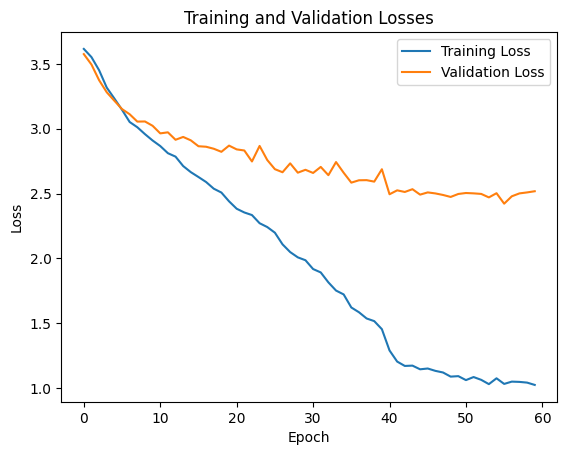

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use Cross-Entropy Loss for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent with momentum

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            if cuda_available:
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if cuda_available:
                    inputs, labels = inputs.cuda(), labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, num_epochs=60)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Task 5 - Evaluate the Model

In [21]:
# Dataloader for the test set
test_loader = torch.utils.data.DataLoader(test_dataset_resized, batch_size=64, shuffle=False)

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if cuda_available:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_loader)

In [22]:
# we show the classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=classes))

Classification Report:
                            precision    recall  f1-score   support

                Abyssinian       0.24      0.31      0.27        98
          American Bulldog       0.26      0.31      0.28       100
 American Pit Bull Terrier       0.08      0.05      0.06       100
              Basset Hound       0.29      0.38      0.33       100
                    Beagle       0.31      0.27      0.29       100
                    Bengal       0.43      0.40      0.41       100
                    Birman       0.27      0.25      0.26       100
                    Bombay       0.43      0.50      0.46        88
                     Boxer       0.21      0.24      0.22        99
         British Shorthair       0.28      0.24      0.26       100
                 Chihuahua       0.16      0.11      0.13       100
              Egyptian Mau       0.51      0.58      0.54        97
    English Cocker Spaniel       0.14      0.12      0.13       100
            English Sett

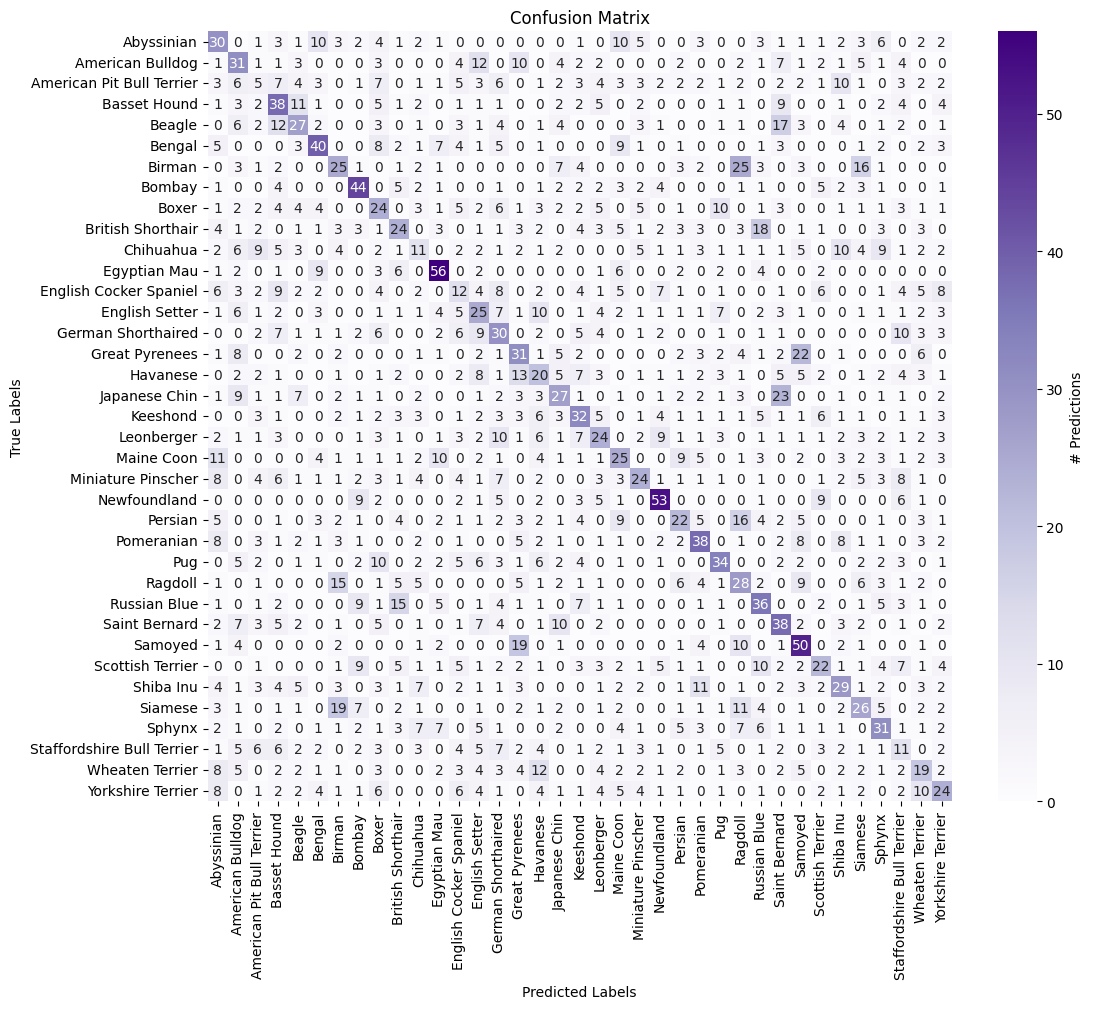

In [25]:
# making confusion matrix
c_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
# making a heatmap using Seaborn
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=classes, yticklabels=classes, cbar_kws={'label': '# Predictions'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()